# ウィルス弱毒化シミュレーションの ABM

(Version 0.0.2)

患者の行動(隔離など)により、「ウィルスの弱毒化」が起きうることを示したい (参: \[cocolog:94891057\](2024年6月) or >>2024-08-09T09:02:59Z )。

強毒のものが隔離される(死亡する)ことで、感染性をもつが、毒性の弱いものが広がりやすくなるはずだ。…という信念である。

これを Grok3 さんに相談してまず SIR 的モデルを作ってもらった(↓)。

https://gist.github.com/JRF-2018/b190e53d792a921f6ca56fa5aebc2c9d

しかし、それは弱毒株と強毒株がすでにある状態のモデルでしかない。そうではなく、どれぐらい弱毒か強毒かが確率的に決まり、どれぐらい感染力があるも確率的に決まるとき、強毒なものほど隔離されるとすると、弱毒かつ感染力があるものが広がりやすいということを示したい。

この場合はエージント・シミュレーションつまり、ABM (Agent-Based Model) がほぼ必要になる。その ABM についても Grok3 さんはシュッと出してきた。

それをさらに拡張して、潜伏期間(感染性あり)もランダムに決まるとき、ロックダウン的政策をすると、潜伏期間の短縮されることも示したいと考えた。こちらも Grok3 さんの補助の元、プログラムしたのだが、結果として私が考えるロックダウン的政策では潜伏期間の短縮がほぼならないことがわかった。これは意外だった。

前回に引き続きの今回の会話は↓から読めるようにしてある。

https://x.com/i/grok/share/Pl9eHC3k5QgrEFkmuTcfBKABz


さて、まずは、強毒なものほど(自主)隔離される…という簡単なモデルをシュッと示そう。

各エージェントは状態（S：感受性(未感染)、I：感染、R：回復、D：死亡、Q：隔離）を持つ。

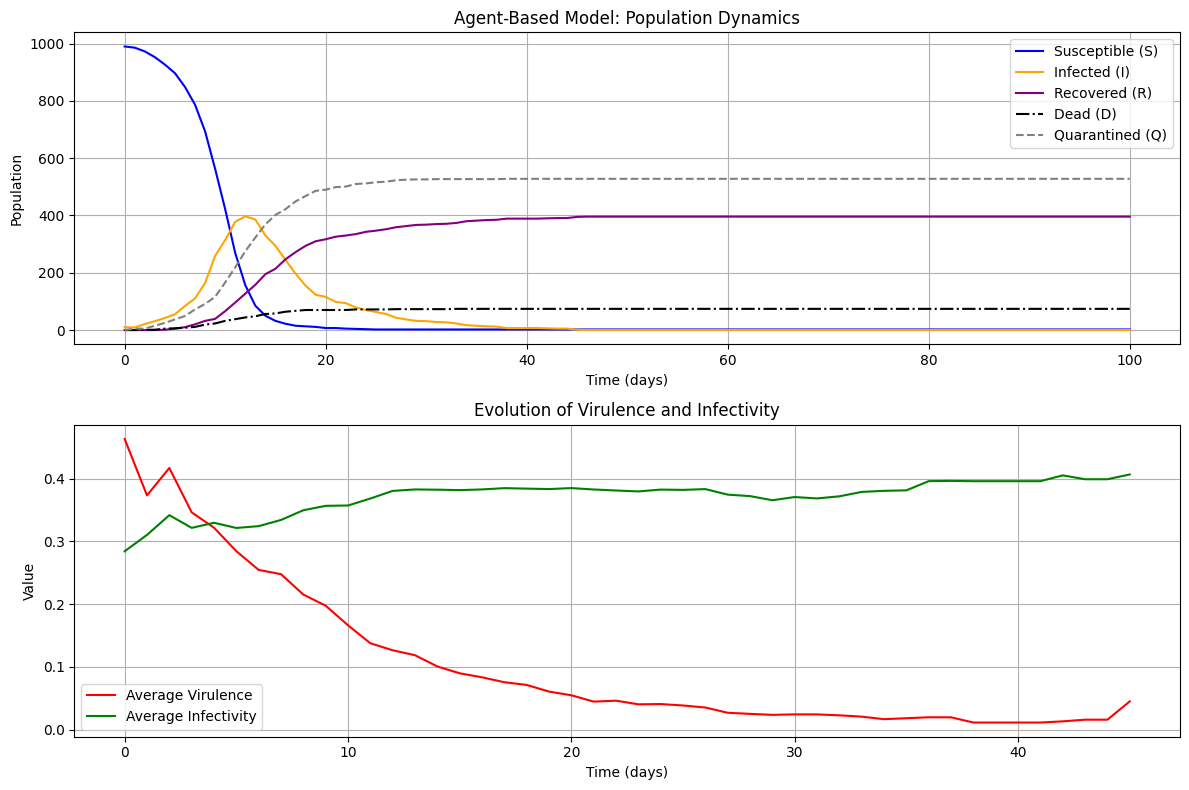

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 乱数シード
np.random.seed(42)

# パラメータ
N = 1000  # 総人口
initial_infected = 10  # 初期感染者
T = 100  # シミュレーション日数
contact_rate = 5  # 1人あたり接触人数/日
recovery_rate = 0.1  # 回復確率/日
virulence_mean = 0.5  # 毒性の平均
virulence_std = 0.2  # 毒性の標準偏差
infectivity_mean = 0.3  # 感染力の平均
infectivity_std = 0.1  # 感染力の標準偏差
mutation_std = 0.05  # 変異の標準偏差

# エージェントの初期化
states = np.array(['S'] * N)  # 状態: S, I, R, D, Q
states[:initial_infected] = 'I'
virulence = np.zeros(N)  # 毒性
infectivity = np.zeros(N)  # 感染力
for i in range(initial_infected):
    virulence[i] = np.clip(np.random.normal(virulence_mean, virulence_std), 0, 1)
    infectivity[i] = np.clip(np.random.normal(infectivity_mean, infectivity_std), 0, 1)

# 記録用
S_count = [N - initial_infected]
I_count = [initial_infected]
R_count = [0]
D_count = [0]
Q_count = [0]
avg_virulence = [virulence[:initial_infected].mean()]
avg_infectivity = [infectivity[:initial_infected].mean()]

# シミュレーション
for t in range(T):
    new_states = states.copy()
    new_virulence = virulence.copy()
    new_infectivity = infectivity.copy()

    # 各感染者について
    for i in np.where(states == 'I')[0]:
        # 隔離
        if np.random.random() < virulence[i]:
            new_states[i] = 'Q'
            continue
        # 回復
        if np.random.random() < recovery_rate:
            new_states[i] = 'R'
            continue
        # 死亡
        if np.random.random() < virulence[i] * 0.2:  # 死亡確率は毒性に比例
            new_states[i] = 'D'
            continue
        # 感染
        contacts = np.random.choice(N, contact_rate, replace=False)
        for j in contacts:
            if states[j] == 'S' and np.random.random() < infectivity[i]:
                new_states[j] = 'I'
                # ウイルス特性の継承（変異あり）
                new_virulence[j] = np.clip(virulence[i] + np.random.normal(0, mutation_std), 0, 1)
                new_infectivity[j] = np.clip(infectivity[i] + np.random.normal(0, mutation_std), 0, 1)

    states = new_states
    virulence = new_virulence
    infectivity = new_infectivity

    # 記録
    S_count.append(np.sum(states == 'S'))
    I_count.append(np.sum(states == 'I'))
    R_count.append(np.sum(states == 'R'))
    D_count.append(np.sum(states == 'D'))
    Q_count.append(np.sum(states == 'Q'))
    infected = states == 'I'
    avg_virulence.append(virulence[infected].mean() if infected.sum() > 0 else np.nan)
    avg_infectivity.append(infectivity[infected].mean() if infected.sum() > 0 else np.nan)

# グラフ描画
plt.figure(figsize=(12, 8))

# 状態人数
plt.subplot(2, 1, 1)
plt.plot(S_count, label='Susceptible (S)', color='blue')
plt.plot(I_count, label='Infected (I)', color='orange')
plt.plot(R_count, label='Recovered (R)', color='purple')
plt.plot(D_count, label='Dead (D)', color='black', linestyle='-.')
plt.plot(Q_count, label='Quarantined (Q)', color='gray', linestyle='--')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Agent-Based Model: Population Dynamics')
plt.legend()
plt.grid(True)

# 平均毒性・感染力
plt.subplot(2, 1, 2)
plt.plot(avg_virulence, label='Average Virulence', color='red')
plt.plot(avg_infectivity, label='Average Infectivity', color='green')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.title('Evolution of Virulence and Infectivity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


さて、ご理解いただけたであろうか？ 弱毒化はこの段階ですでに示されている。ここに潜伏期間を足し、いろいろ工夫したのが次のコードになる。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

N = 1000
T = 200
runs = 100

# シミュレーション補助関数
def calc_risk_1(states, virulence, infectivity, latent_period,
                max_latent, risk_mag):
    infected = (states == 'I')
    avg_virulence_t = virulence[infected].mean() if infected.sum() > 0 else 0
    avg_infectivity_t = infectivity[infected].mean() if infected.sum() > 0 else 0
    avg_latent_t = latent_period[infected].mean() if infected.sum() > 0 else 0
    risk = min(avg_virulence_t, avg_infectivity_t, avg_latent_t / max_latent) * risk_mag
    return risk

# シミュレーション関数
def run_simulation(seed, N=N, initial_infected=10, T=T, base_contact_rate=5,
                   recovery_rate=0.1, virulence_mean=0.5, virulence_std=0.2,
                   infectivity_mean=0.3, infectivity_std=0.1, latent_mean=5.0,
                   latent_std=2.0, mutation_std=0.05, latent_mutation_std=0.2,

                   max_latent = 10,
                   latent_infectivity_mag = 0.3,
                   latent_mutation_mean = -0.3,
                   isolation_mag = 2,
                   infection_effect = 2.5,
                   risk_mag = 1.5, calc_risk = calc_risk_1,
                   ):
    #np.random.seed(seed)

    # 初期化
    states = np.array(['S'] * N)
    states[:initial_infected] = 'E'
    virulence = np.zeros(N)
    infectivity = np.zeros(N)
    latent_period = np.zeros(N)
    latent_time = np.zeros(N)
    for i in range(initial_infected):
        virulence[i] = np.clip(np.random.normal(virulence_mean, virulence_std), 0, 1)
        infectivity[i] = np.clip(np.random.normal(infectivity_mean, infectivity_std), 0, 1)
        latent_period[i] = np.clip(np.random.normal(latent_mean, latent_std), 1, 10)

    # 記録
    S_count = [N - initial_infected]
    E_count = [initial_infected]
    I_count = [0]
    R_count = [0]
    D_count = [0]
    Q_count = [0]
    RF_count = [0] #リスクの記録用
    avg_virulence = [virulence[:initial_infected].mean()]
    avg_infectivity = [infectivity[:initial_infected].mean()]
    avg_latent = [latent_period[:initial_infected].mean() / max_latent]

    # シミュレーション
    for t in range(T):
        new_states = states.copy()
        new_virulence = virulence.copy()
        new_infectivity = infectivity.copy()
        new_latent_period = latent_period.copy()
        latent_time = latent_time + (states == 'E')

        # 平均毒性、感染力、潜伏期間に基づくコンタクト制限
        risk = calc_risk(states, virulence, infectivity, latent_period,
                         max_latent, risk_mag)
        restriction_factor = (1 - risk)**2 if risk < 1 else 0
        contact_rate = np.clip(int(base_contact_rate * restriction_factor),
                               1, int(base_contact_rate))

        # 潜伏感染者（E）
        for i in np.where(states == 'E')[0]:
            if latent_time[i] >= latent_period[i]:
                new_states[i] = 'I'
                latent_time[i] = 0
                continue
            if contact_rate > 0:
                contacts = np.random.choice(N, contact_rate, replace=False)
                for j in contacts:
                    if states[j] == 'S' and np.random.random() < infectivity[i] * latent_infectivity_mag:
                        new_states[j] = 'E'
                        new_virulence[j] = np.clip(virulence[i] + np.random.normal(0, mutation_std), 0, 1)
                        new_infectivity[j] = np.clip(infectivity[i] + np.random.normal(0, mutation_std), 0, 1)
                        new_latent_period[j] = np.clip(latent_period[i] + np.random.normal(latent_mutation_mean, latent_mutation_std), 1, max_latent)

        # 症状あり感染者（I）
        for i in np.where(states == 'I')[0]:
            if np.random.random() < virulence[i]**isolation_mag:
                new_states[i] = 'Q'
                continue
            if np.random.random() < recovery_rate:
                new_states[i] = 'R'
                continue
            if np.random.random() < virulence[i] * 0.2:
                new_states[i] = 'D'
                continue
            effective_contact_rate = int(contact_rate * infection_effect) if contact_rate > 0 else 1
            contacts = np.random.choice(N, effective_contact_rate, replace=False)
            for j in contacts:
                if states[j] == 'S' and np.random.random() < infectivity[i]:
                    new_states[j] = 'E'
                    new_virulence[j] = np.clip(virulence[i] + np.random.normal(0, mutation_std), 0, 1)
                    new_infectivity[j] = np.clip(infectivity[i] + np.random.normal(0, mutation_std), 0, 1)
                    new_latent_period[j] = np.clip(latent_period[i] + np.random.normal(latent_mutation_mean, latent_mutation_std), 1, max_latent)

        # 隔離状態（Q）
        for i in np.where(states == 'Q')[0]:
            if np.random.random() < recovery_rate:
                new_states[i] = 'R'
                continue
            if np.random.random() < virulence[i] * 0.2:
                new_states[i] = 'D'
                continue

        states = new_states
        virulence = new_virulence
        infectivity = new_infectivity
        latent_period = new_latent_period

        S_count.append(np.sum(states == 'S'))
        E_count.append(np.sum(states == 'E'))
        I_count.append(np.sum(states == 'I'))
        R_count.append(np.sum(states == 'R'))
        D_count.append(np.sum(states == 'D'))
        Q_count.append(np.sum(states == 'Q'))
        RF_count.append(restriction_factor)
        infected = (states == 'E') | (states == 'I') | (states == 'Q')
        avg_virulence.append(virulence[infected].mean() if infected.sum() > 0 else np.nan)
        avg_infectivity.append(infectivity[infected].mean() if infected.sum() > 0 else np.nan)
        avg_latent.append(latent_period[infected].mean() / max_latent if infected.sum() > 0 else np.nan)

    return S_count, E_count, I_count, R_count, D_count, Q_count, RF_count, avg_virulence, avg_infectivity, avg_latent

# 複数シミュレーション
def plot_simulation(run_simulation, base="plt", runs=runs, N=N, T=T):
    all_S, all_E, all_I, all_R, all_D, all_Q = [], [], [], [], [], []
    all_virulence, all_infectivity, all_latent = [], [], []
    all_IEQ, all_RF = [], []
    for i in range(runs):
        S_count, E_count, I_count, R_count, D_count, Q_count, RF_count, avg_virulence, avg_infectivity, avg_latent = run_simulation(seed=i, N=N, T=T)
        all_S.append(S_count)
        all_E.append(E_count)
        all_I.append(I_count)
        all_R.append(R_count)
        all_D.append(D_count)
        all_Q.append(Q_count)
        all_RF.append(RF_count)
        IEQ_count = [(i + e + q) / N for i,e,q in zip(I_count, E_count, Q_count)]
        all_IEQ.append(IEQ_count)
        all_virulence.append(avg_virulence)
        all_infectivity.append(avg_infectivity)
        all_latent.append(avg_latent)

    # 平均と信頼区間
    mean_virulence = np.nanmean(all_virulence, axis=0)
    se_virulence = sem(all_virulence, axis=0, nan_policy='omit')
    mean_infectivity = np.nanmean(all_infectivity, axis=0)
    se_infectivity = sem(all_infectivity, axis=0, nan_policy='omit')
    mean_latent = np.nanmean(all_latent, axis=0)
    se_latent = sem(all_latent, axis=0, nan_policy='omit')
    mean_IEQ = np.nanmean(all_IEQ, axis=0)
    se_IEQ = sem(all_IEQ, axis=0, nan_policy='omit')
    mean_RF = np.nanmean(all_RF, axis=0)
    se_RF = sem(all_RF, axis=0, nan_policy='omit')

    # グラフ描画
    plt.figure(figsize=(12, 10))

    # 状態人数（代表例）
    plt.subplot(2, 1, 1)
    plt.plot(all_S[0], label='Susceptible (S)', color='blue')
    plt.plot(all_E[0], label='Exposed (E)', color='yellow')
    plt.plot(all_I[0], label='Infected (I)', color='orange')
    plt.plot(all_R[0], label='Recovered (R)', color='purple')
    plt.plot(all_D[0], label='Dead (D)', color='black', linestyle='-.')
    plt.plot(all_Q[0], label='Quarantined (Q)', color='gray', linestyle='--')
    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.title('Agent-Based Model: Population Dynamics (Single Run)')
    plt.legend()
    plt.grid(True)

    # 平均特性（信頼区間付き）
    plt.subplot(2, 1, 2)
    plt.plot(mean_virulence, label='Average Virulence', color='red')
    plt.fill_between(range(T+1), mean_virulence - 1.96*se_virulence, mean_virulence + 1.96*se_virulence, color='red', alpha=0.2)
    plt.plot(mean_infectivity, label='Average Infectivity', color='green')
    plt.fill_between(range(T+1), mean_infectivity - 1.96*se_infectivity, mean_infectivity + 1.96*se_infectivity, color='green', alpha=0.2)
    plt.plot(mean_latent, label='Average Latent Period', color='blue')
    plt.fill_between(range(T+1), mean_latent - 1.96*se_latent, mean_latent + 1.96*se_latent, color='blue', alpha=0.2)
    plt.plot(mean_IEQ, label='Average I+E+Q', color='yellow')
    plt.fill_between(range(T+1), mean_IEQ - 1.96*se_IEQ, mean_IEQ + 1.96*se_IEQ, color='yellow', alpha=0.2)
    plt.plot(mean_RF, label='Average RF', color='orange')
    plt.fill_between(range(T+1), mean_RF - 1.96*se_RF, mean_RF + 1.96*se_RF, color='orange', alpha=0.2)
    plt.xlabel('Time (days)')
    plt.ylabel('Value')
    plt.title('Evolution of Virulence, Infectivity, and Latent Period (Mean ± 95% CI)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(base + "-a.png")
    plt.show()


まず Grok3 さんオススメの設定をやってみよう。説明は後回し。

<ipython-input-2-db4eeab80586>:157: RuntimeWarning: Mean of empty slice
  mean_virulence = np.nanmean(all_virulence, axis=0)
<ipython-input-2-db4eeab80586>:158: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_virulence = sem(all_virulence, axis=0, nan_policy='omit')
<ipython-input-2-db4eeab80586>:159: RuntimeWarning: Mean of empty slice
  mean_infectivity = np.nanmean(all_infectivity, axis=0)
<ipython-input-2-db4eeab80586>:160: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_infectivity = sem(all_infectivity, axis=0, nan_policy='omit')
<ipython-input-2-db4eeab80586>:161: RuntimeWarning: Mean of empty slice
  mean_latent = np.nanmean(all_latent, axis=

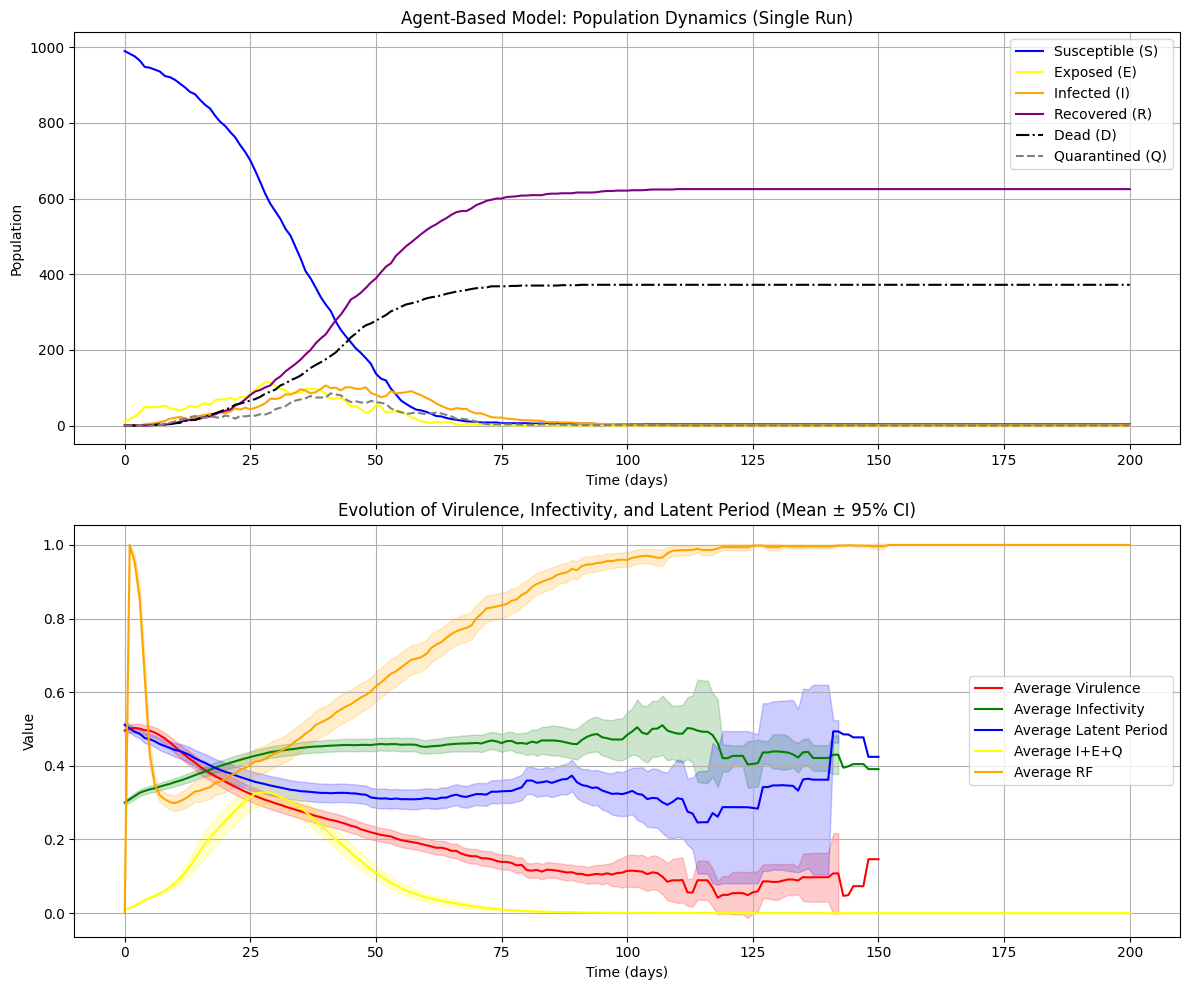

In [ ]:
plot_simulation(lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.3,
                               latent_mutation_mean = -0.3,
                               isolation_mag = 2.0,
                               infection_effect = 2.5,
                               risk_mag = 1.5, calc_risk = calc_risk_1),
                base="plt-7b-o")


latent_infectivity_mag = 0.3 は、潜伏期間中の感染力を若干弱める意味がある。

latent_mutation_mean = -0.3 は、潜伏期間を長くするのは進化的にコストがかかるため、通常は潜伏期間が短くなるよう進化することを表している。

isolation_mag = 2.0 は、症状のある感染者が２乗に比例して自主隔離を行うことを表している。ちなみに最初のモデルでは隔離者 Q は Q のままだったが、新しいモデルでは Q は R (回復) か D (死亡) に移行するようになっている。

infection_effect = 2.5 は感染者のコンタクト数を増やす効果がある。症状ありの感染者（例：咳や発熱）は感染力が一時的に高まる場合がある…ため正当化できるというのが Grok3 さんの主張。

risk_mag = 1.5 は、全体リスクの計算において、それを強めに見ることを表している。全体リスクが高いとコンタクト数が制限される(ロックダウンがきつくなる)。

calc_risk = calc_risk_1 は、全体リスクの計算において、感染力の平均値・毒性の平均値・(潜伏期間/最大潜伏期間)の平均値 のうち、最小のものを全体リスクとみなす戦略を選択することを示す。これは比較的現実的な政策で、感染力が強く毒性が強くかつ潜伏期間が長い「危険なウイルス」でなければ、政策が発動しないという条件になる。

下側のグラフの黄色い線が、隔離者なども含めた感染者総数(割合)である。感染がほぼ終息してからのグラフはほとんど意味がない。

下側のグラフのオレンジの線は、ロックダウン的政策の強度である。

この結果において、潜伏期間の短縮が起きているのは、単に潜伏期間が短くなるように進化するようにしたのが効いているためである。

次に私が標準的に使う設定で calc_risk の戦略だけが Grok さんオススメの物になっているものを試してみよう。

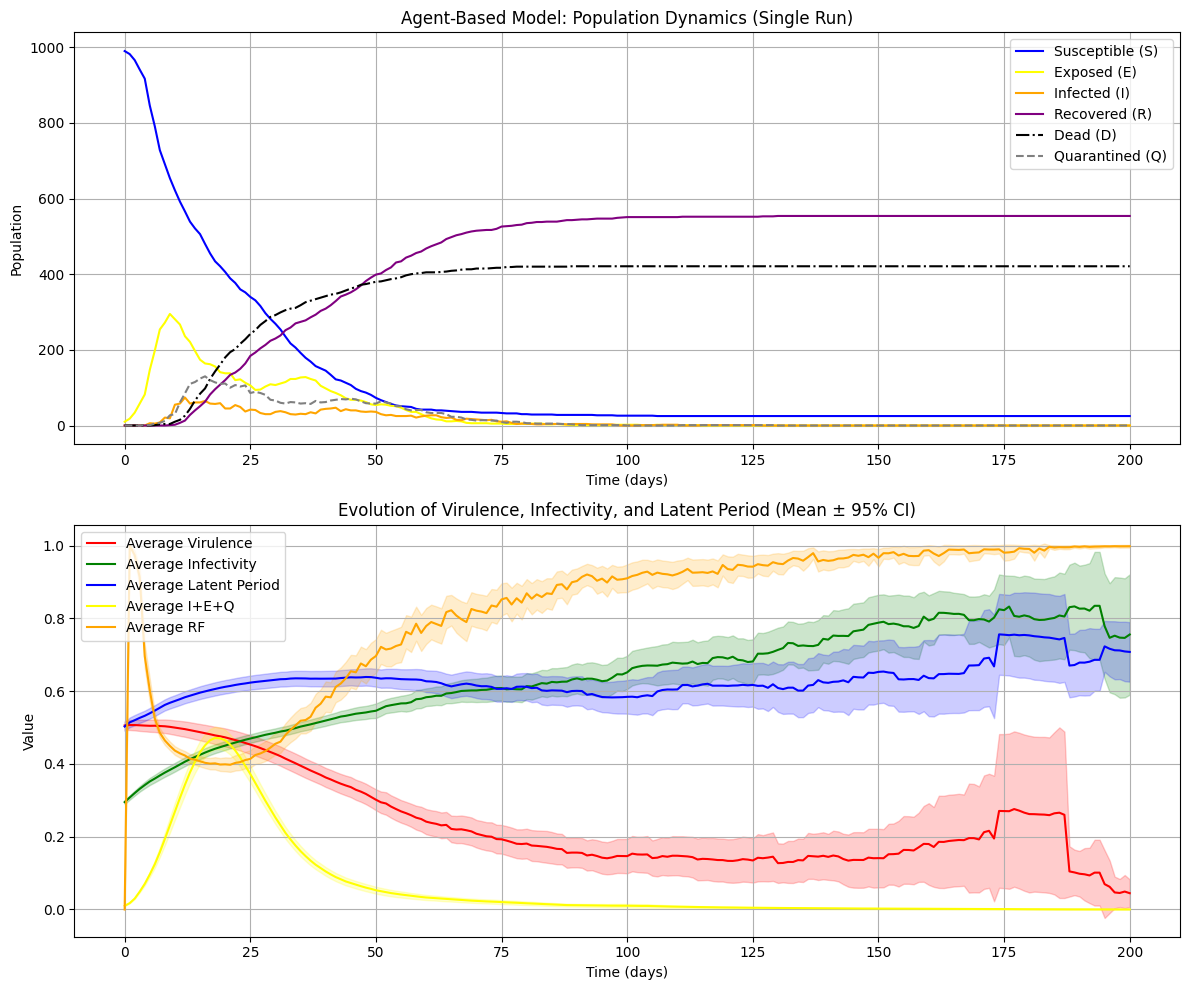

In [ ]:
plot_simulation(lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.5,
                               latent_mutation_mean = 0.0,
                               isolation_mag = 1.0,
                               infection_effect = 1.0,
                               risk_mag = 1.0, calc_risk = calc_risk_1),
                base="plt-7b-1")


latent_infectivity_mag = 0.5 は、潜伏期間中の感染力を若干弱める意味があるのは Grok さんオススメと変わらないが、弱める度合いをそこまで気合いを入れてない。普通に半分にした。…という意味合いである。

latent_mutation_mean = 0.0 は、通常は潜伏期間が短くなるよう進化はふつうあるのかもしれないが、政策効果を知るためにあえて、そういう進化は起きないとすることを表している。

isolation_mag = 1.0 は、症状のある感染者が単純に比例して自主隔離を行うことを表している。最初のモデルにあわせてある。

infection_effect = 1.0 は感染者のコンタクト数を無理に増やさない。latent_infectivity_mag = 0.5 でも効果はあるはずだから政策に注目するだけならそれでよいはず。。

risk_mag = 1.0 は、全体リスクの計算において、特に強めることなく単純に素直に評価することを表している。


結果としては潜伏期間の短縮は起こっていない。弱毒化や高感染性化は起こっている。

次は calc_risk を少し変えよう。感染力の平均などを見ていたが平均ではなく最大値を見るようにする。最大値をどう観測するんだという問題はあるが、発見された最も強いものを選んで指標に使うのに近いという意味で、これも割と現実的な政策になろうかと思う。

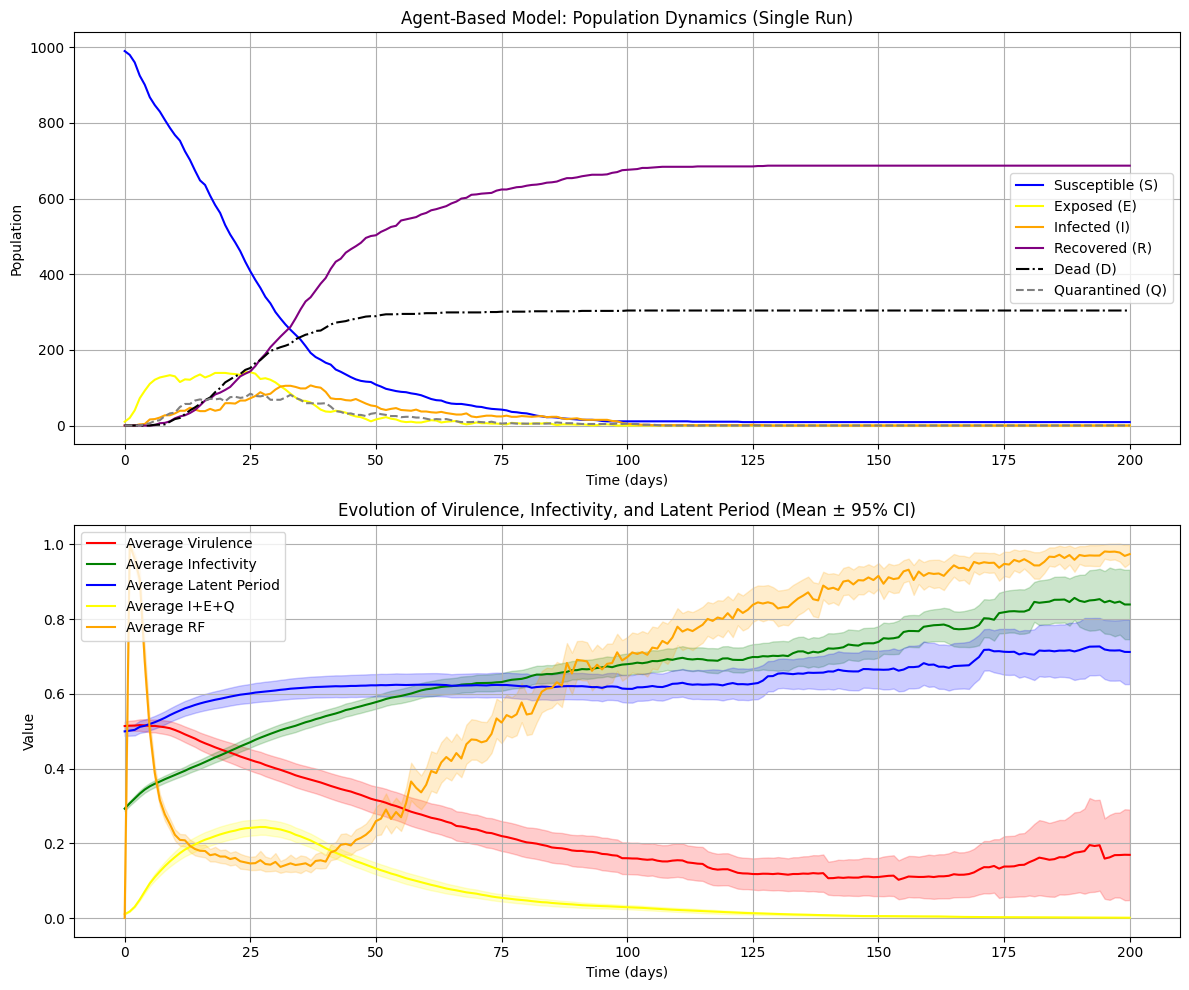

In [ ]:
def calc_risk_2(states, virulence, infectivity, latent_period,
                max_latent, risk_mag):
    infected = (states == 'I')
    max_virulence_t = max(virulence[infected]) if infected.sum() > 0 else 0
    max_infectivity_t = max(infectivity[infected]) if infected.sum() > 0 else 0
    max_latent_t = max(latent_period[infected]) if infected.sum() > 0 else 0
    risk = min(max_virulence_t, max_infectivity_t, max_latent_t / max_latent) * risk_mag
    return risk

plot_simulation(lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.5,
                               latent_mutation_mean = 0.0,
                               isolation_mag = 1.0,
                               infection_effect = 1.0,
                               risk_mag = 1.0, calc_risk = calc_risk_2),
                base="plt-7b-2")


calc_risk を変えただけである。下側のグラフのオレンジの線に注目すると、ロックダウンが先の物よりキツくなっているのがわかる。今回はおそらくそのために感染者の山がなだらかになっている。しかし期待されたような潜伏期間の短縮はほぼない。

次は calc_risk を変えてみよう。これまで政策は感染力・毒性・潜伏期間に注目していたが、これを最大潜伏期間にのみ注目してロックダウン的政策をかけることにする。潜伏期間に作用できるなら、これで最大効果が得られるはずであろう。…と私は考えた。

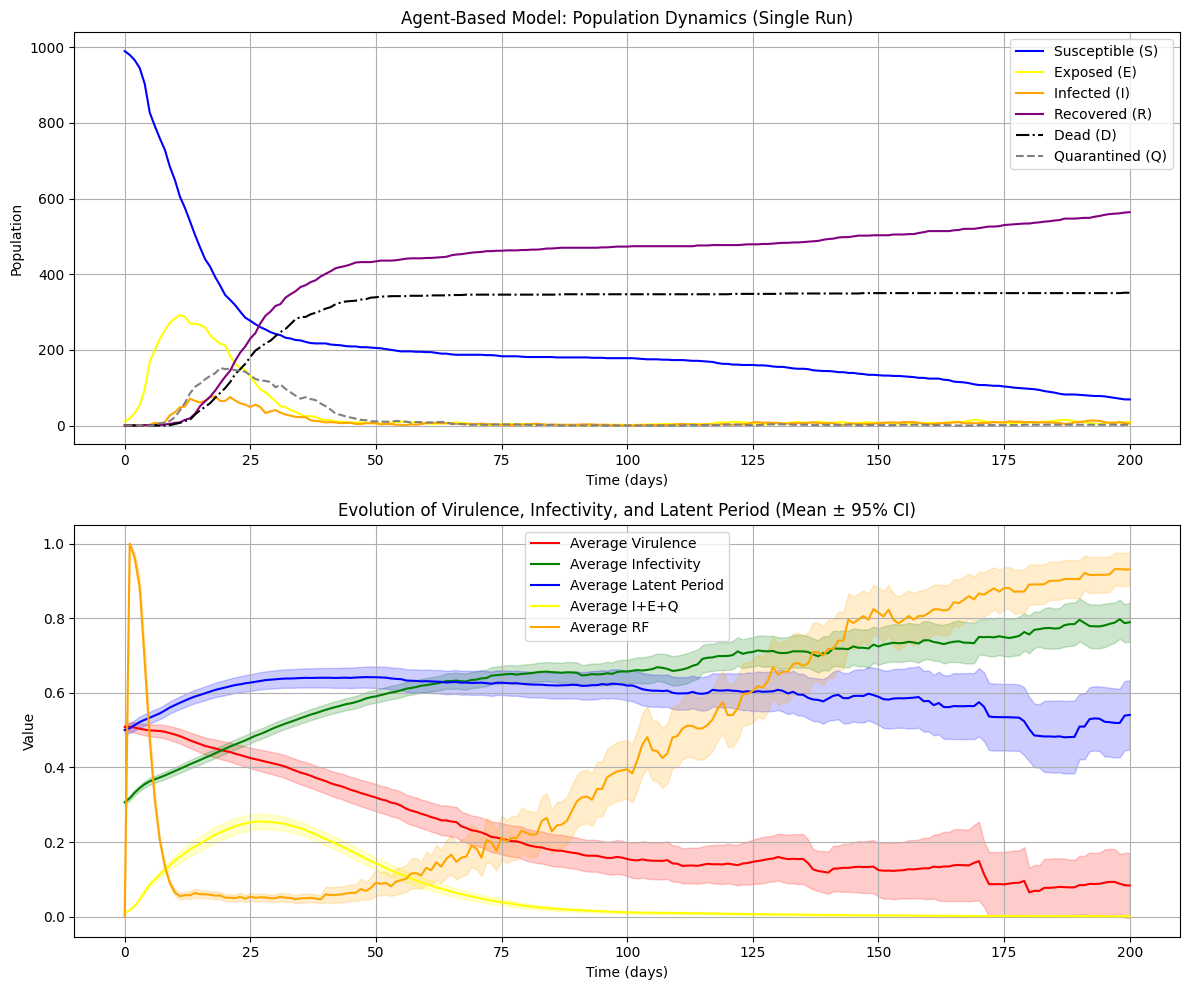

In [ ]:
def calc_risk_3(states, virulence, infectivity, latent_period,
                max_latent, risk_mag):
    infected = (states == 'I')
    max_latent_t = max(latent_period[infected]) if infected.sum() > 0 else 0
    risk = (max_latent_t / max_latent) * risk_mag
    return risk

plot_simulation(lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.5,
                               latent_mutation_mean = 0.0,
                               isolation_mag = 1.0,
                               infection_effect = 1.0,
                               risk_mag = 1.0, calc_risk = calc_risk_3),
                base="plt-7b-3")


calc_risk を変えただけである。予想通り、ロックダウンはかなりきつくなっている。山のなだらかさはあまり変わらない感じだが。にもかかわらず、潜伏期間の短縮は見られない。ほぼ政策倒れである。

では政策がない場合どうなるか。比較してみよう。これは calc_risk を単に 0 を返す関数にすれば実現できる。

<ipython-input-2-db4eeab80586>:157: RuntimeWarning: Mean of empty slice
  mean_virulence = np.nanmean(all_virulence, axis=0)
<ipython-input-2-db4eeab80586>:158: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_virulence = sem(all_virulence, axis=0, nan_policy='omit')
<ipython-input-2-db4eeab80586>:159: RuntimeWarning: Mean of empty slice
  mean_infectivity = np.nanmean(all_infectivity, axis=0)
<ipython-input-2-db4eeab80586>:160: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_infectivity = sem(all_infectivity, axis=0, nan_policy='omit')
<ipython-input-2-db4eeab80586>:161: RuntimeWarning: Mean of empty slice
  mean_latent = np.nanmean(all_latent, axis=

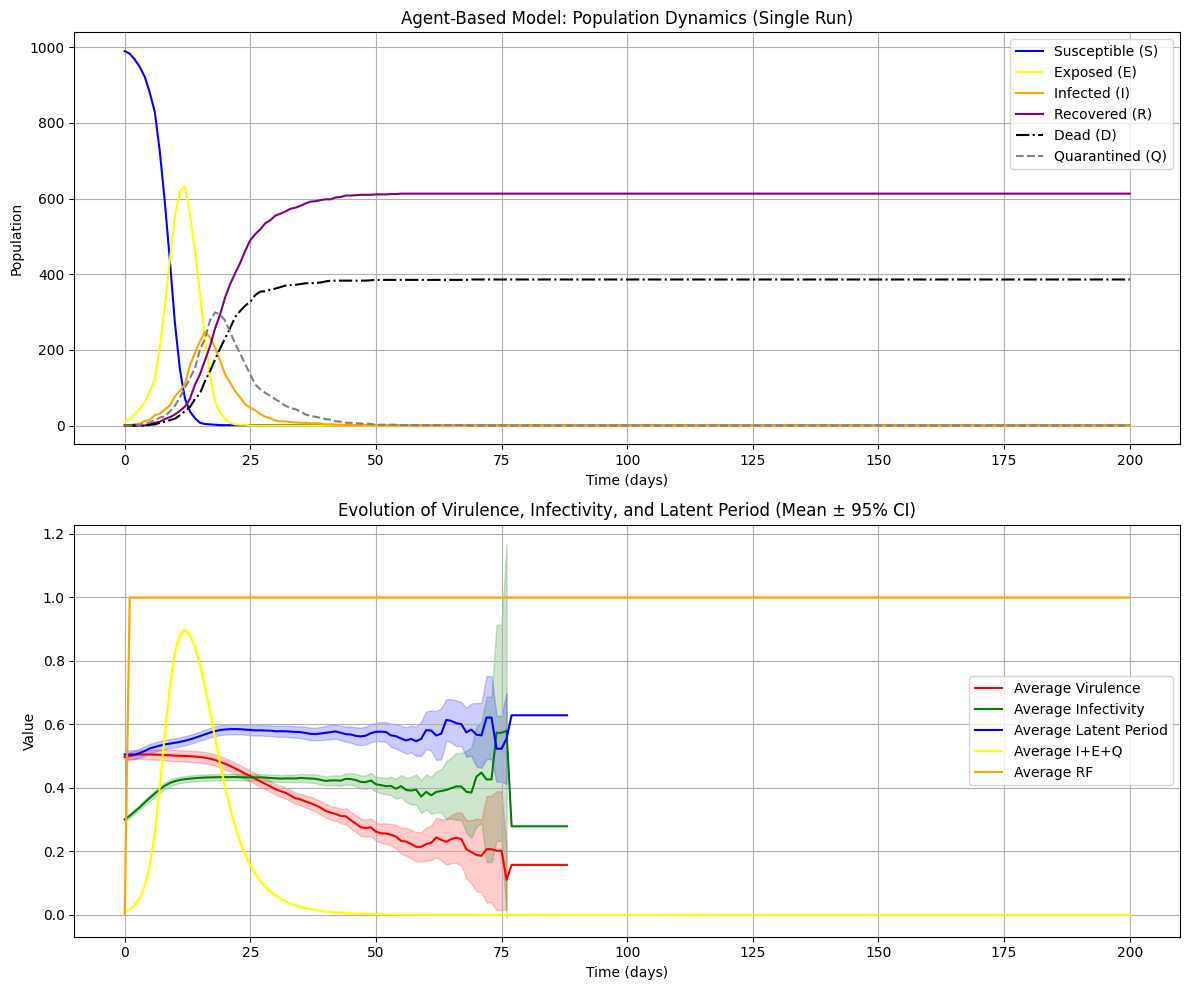

In [ ]:
def calc_risk_0(states, virulence, infectivity, latent_period,
                max_latent, risk_mag):
    return 0

plot_simulation(lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.5,
                               latent_mutation_mean = 0.0,
                               isolation_mag = 1.0,
                               infection_effect = 1.0,
                               risk_mag = 1.0, calc_risk = calc_risk_0),
                base="plt-7b-0")


山はとても急になったが、実は私はこれでも潜伏期間の短縮は起きるのではないかと当初考えていた。なぜなら、潜伏期間中の感染力は弱められているため、早く潜伏期間が終わったほうが、感染機会が増える。よって、隔離されにくい弱毒の潜伏期間の短い物のほうが、適者生存する。…と考えたからだ。

しかし、結果を見る限りほぼそうなっていない。

潜伏期間中の感染力の弱め方がまだ足りないのだろうか？ より弱めるためlatent_infectivity_mag を 0.5 から 0.1 にして試してみよう。

<ipython-input-2-db4eeab80586>:157: RuntimeWarning: Mean of empty slice
  mean_virulence = np.nanmean(all_virulence, axis=0)
<ipython-input-2-db4eeab80586>:158: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_virulence = sem(all_virulence, axis=0, nan_policy='omit')
<ipython-input-2-db4eeab80586>:159: RuntimeWarning: Mean of empty slice
  mean_infectivity = np.nanmean(all_infectivity, axis=0)
<ipython-input-2-db4eeab80586>:160: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_infectivity = sem(all_infectivity, axis=0, nan_policy='omit')
<ipython-input-2-db4eeab80586>:161: RuntimeWarning: Mean of empty slice
  mean_latent = np.nanmean(all_latent, axis=

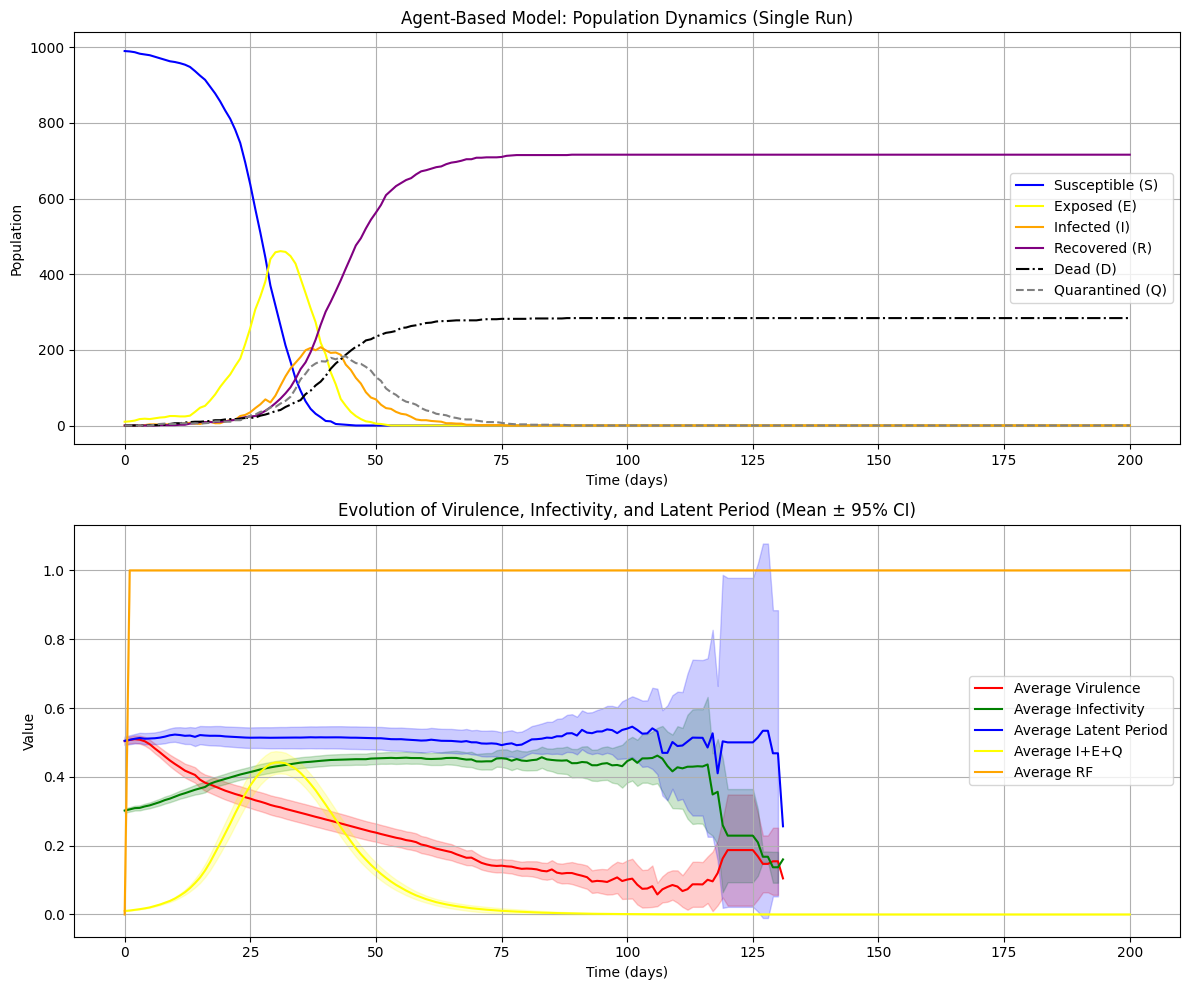

In [ ]:
plot_simulation(lambda seed, N, T:
                run_simulation(seed=seed, N=N, T=T,
                               latent_infectivity_mag = 0.1,
                               latent_mutation_mean = 0.0,
                               isolation_mag = 1.0,
                               infection_effect = 1.0,
                               risk_mag = 1.0, calc_risk = calc_risk_0),
                base="plt-7b-0-1")


潜伏期間中の短縮はほぼ起きてないといえるだろう。まぁ、あれだけ強い政策を行っても短縮はならなかったのだから、この程度のことではビクともしないのだろう。

ただ、潜伏期間の大きくなり方が 0.5 のときより 0.1 のほうが少ないとは言えそうで、「短縮」と言えるものはないが、それっぽい効果はあると言えるのかもしれない。

すると通常は潜伏期間が(一時的に)増えるのが常態というのを認めることになるわけだが、なぜならそれは潜伏期間が長いほうが有利すぎるから…と言いたいわけだが、それにしては一方的な増加にもならないのが解せない。

さて今回用意した実験は以上である。

実はこれ以外にも無理やり潜伏期間の短縮を起こすため、感染者(I)の毒性があるほうが隔離されるという部分で、

            if np.random.random() < ((virulence[i] \
                                      * (latent_period[i] / max_latent))
                                     ** isolation_mag):

…などとして潜伏期間が小さいものは、隔離されにくくなる…みたいなコードも試したのだが、ここまで強力なことをしても、短縮と言えるほどのことは起きなかった。(さらに latent_infectivity_mag = 0.1 と組み合わせると結構短縮は起こったが。)

結論として繰り返すが、いずれにせよ、弱毒化・高感染性化は言えるが、政策による潜伏期間の短縮はできなかった。

他に良い政策・または、変えるべき前提はあるのだろうか？ ご教授いただければ幸いです。